# Capstone Project - Analysis of SDOT Accidents in Cold Conditions 
### Applied Data Science Capstone by IBM/Coursera

## Introduction <a name="introduction"></a>

In this project, we will be digging deeper into the accident data provided to us from the Seattle Department of Transportation (SDOT). The question we aim to answer is this: ***What specific roads in Seattle are most prone to accidents when affected by snow and ice?*** 

We are confident that our findings would be of good use to the SDOT and its associated government agencies (including, but not limited to the Seattle Police Department). For one thing, it would result in more efficient allocation of their resources to prevent injuries and damage to property caused by accidents in the area.

As an effect, the general populace of the city of Seattle would be safer, knowing those who watch over them have more information at their disposal.


## Data <a name="data"></a>

The data we have on hand is quite extensive, providing us with relevant attributes such as the location and time of the accident, as well as the consequent weather and lighting conditions when the event occurred. There are also details indicating how many pedestrians were involved, or if one or more cars that were affected were parked or not.

#### Breakdown

For this particular case, the Dependent Variable to predict will be the severity of the accident, or **SEVERITYCODE**. Note that the Severity Codes in the provided CSV file are only limited to two values: 1 and 2. According to the supplementary Metadata file, **SEVERITYCODE 1** corresponds to **Property Damage** and **2** corresponds to **Injury**. Thus, the model we will create will be geared towards ***predicting the likelihood of a potential accident to lead to Property Damage or Injury.***

**NOTE:** There were other Severity Codes disclosed on the Metadata: 0 (Unknown), 2b (Serious Injury), and 3 (Fatality). We believe these were omitted because the dataset already had thousands of rows to work on without these Severity Codes. 0 (Unknown) was most likely omitted because of its potential to confuse the model. Finally, we believe 2 (Injury) would be of utmost importance because we don't want to wait for serious injuries or fatalities to happen before we work on data. In other words if we could prevent injury we could definitely prevent worse things from happening. 


We have chosen to work with the following Attributes:

* **X, Y** - Coordinates of the general location of the collision. 
* **JUNCTIONTYPE** - Category of junction at which collision took place
* **WEATHER** - A description of the weather conditions during the time of the collision. 
* **ROADCOND** - The condition of the road during the collision.
* **LIGHTCOND** - The light conditions during the collision. 
* **SPEEDING** - Whether or not speeding was a factor in the collision.

These descriptions were gathered from the supplementary Metadata file. 

These are the columns we dropped, due to their lesser relevance, string properties, or because they are details of the accident after the fact:
**LOCATION, PERSONCOUNT, VEHCOUNT, INCDATE, INCDTTM, OBJECTID, INCKEY, COLDETKEY, REPORTNO, STATUS, ADDRTYPE, INTKEY, EXCEPTRSNCODE, EXCEPTRSNDESC, Duplicate SEVERITYCODE, COLLISIONTYPE, PEDCOUNT, PEDCYLCOUNT, SDOT_COLCODE, SDOT_COLDESC, INATTENTIONIND, UNDERINFL, PEDROWNOTGRNT, SDOTCOLNUM, ST_COLCODE, ST_COLDESC, SEGLANEKEY, CROSSWALKKEY, HITPARKEDCAR, SEVERITYDESC**


### Data Selection/Cleaning

In [1]:
# Importing Libraries

import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

In [2]:
#Getting file from Coursera Link

!wget -O Data-Collisions.csv https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv

--2020-09-07 05:26:15--  https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv
Resolving s3.us.cloud-object-storage.appdomain.cloud (s3.us.cloud-object-storage.appdomain.cloud)... 67.228.254.196
Connecting to s3.us.cloud-object-storage.appdomain.cloud (s3.us.cloud-object-storage.appdomain.cloud)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73917638 (70M) [text/csv]
Saving to: ‘Data-Collisions.csv’

Data-Collisions.csv 100%[===================>]  70.49M  20.8MB/s    in 3.5s    

2020-09-07 05:26:19 (20.4 MB/s) - ‘Data-Collisions.csv’ saved [73917638/73917638]



In [3]:
#Read CSV
path = 'Data-Collisions.csv'
df_raw = pd.read_csv(path)
df_raw.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [5]:
#Extracting Columns.

df = df_raw[['SEVERITYCODE', 'X', 'Y', 'JUNCTIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'SPEEDING']]
print(df.shape)
print(df.dtypes)

(194673, 8)
SEVERITYCODE      int64
X               float64
Y               float64
JUNCTIONTYPE     object
WEATHER          object
ROADCOND         object
LIGHTCOND        object
SPEEDING         object
dtype: object


Converted NaN values in Column SPEEDING to 'N'. Dropping all other Rows with NaN and Unknown/Other 

In [ ]:
df.dropna(subset=['SEVERITYCODE', 'X', 'Y', 'JUNCTIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND'],inplace=True)
df['SPEEDING'].fillna('N', inplace=True)
df.shape

In [ ]:
for y in df.columns:
    index_names = df[(df[y] == 'Unknown')].index 
    df.drop(index_names, inplace = True)

    index_names = df[(df[y] == 'Other')].index 
    df.drop(index_names, inplace = True)



### Data Extraction

The dataframe has been 'cleaned' of NaN and 'Unknown'/'Other' values. We will now draw all rows with ROADCOND of 'Snow/Slush' and 'Ice'.

In [9]:
array=['Snow/Slush', 'Ice']
df_snow = df[df['ROADCOND'].isin(array)]

df_snow.shape

(1865, 8)

### Visualization

In [10]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium

print('Folium installed and imported!')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Folium installed and imported!


In [11]:
seattle_map = folium.Map(location=[47.608013, - 122.335167], zoom_start=12)

seattle_map

Seattle Map plotted, now plotting each accident point:

In [13]:
accidents = folium.map.FeatureGroup()

for lat, lng, in zip(df_snow.Y, df_snow.X):
    accidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=1,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.6
        )
    )

# add incidents to map
seattle_map.add_child(accidents)

We could go through each point and make conclusions from here but we can also use Folium to group points for us.

In [15]:
from folium import plugins

seattle_map = folium.Map(location=[47.608013, - 122.335167], zoom_start=12)

acc_cat = plugins.MarkerCluster().add_to(seattle_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(df_snow.Y, df_snow.X, df_snow.SEVERITYCODE):
    folium.Marker(
        location=[lat, lng],
        icon=None,
    ).add_to(acc_cat)

# display map
seattle_map

### Additional Analysis

We can take a look at some of the columns on their own for more details on what we can keep an eye out for in case of cold weather.

In [43]:
df_snow['JUNCTIONTYPE'].value_counts()

Mid-Block (not related to intersection)              1198
At Intersection (intersection related)                340
Mid-Block (but intersection related)                  244
Driveway Junction                                      55
At Intersection (but not related to intersection)      25
Ramp Junction                                           3
Name: JUNCTIONTYPE, dtype: int64

In [49]:
df_snow['WEATHER'].value_counts()

Clear                       697
Snowing                     636
Overcast                    340
Raining                     103
Sleet/Hail/Freezing Rain     43
Fog/Smog/Smoke               35
Blowing Sand/Dirt             8
Severe Crosswind              3
Name: WEATHER, dtype: int64

In [48]:
#df_snow.groupby(['ROADCOND'])['LIGHTCOND'].value_counts()
df_snow['LIGHTCOND'].value_counts()

Dark - Street Lights On     850
Daylight                    846
Dawn                         81
Dusk                         35
Dark - No Street Lights      31
Dark - Street Lights Off     22
Name: LIGHTCOND, dtype: int64

This tells us that there can be as many snow/ice related accidents in daylight as there are at night (regardless of whether street lights are on/present or not). There can also be as many of these accidents in clear weather as there would be in snowing weather. 

However, accidents concerning Mid-Blocks that are not related to intersection stand out. 

### Modelling: K-Nearest Neighbors

For whatever purpose it may serve, we have also prepared a KNN model to predict the potential Severity of an accident given the Location, Junction Type, Weather/Road/Light Conditions, as well as if the vehicle in question was speeding. 

#### Train/Test Split

In [25]:
X = df_snow[['X', 'Y', 'JUNCTIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'SPEEDING']].values
X[0:5]

array([[-122.3107425, 47.63992717,
        'Mid-Block (not related to intersection)', 'Snowing',
        'Snow/Slush', 'Dark - Street Lights On', 'N'],
       [-122.3660043, 47.68583035,
        'Mid-Block (not related to intersection)',
        'Sleet/Hail/Freezing Rain', 'Ice', 'Dark - Street Lights On',
        'N'],
       [-122.3018681, 47.61893057,
        'Mid-Block (not related to intersection)', 'Clear', 'Ice',
        'Dusk', 'N'],
       [-122.28995309999999, 47.68304771,
        'Mid-Block (but intersection related)', 'Snowing', 'Snow/Slush',
        'Daylight', 'Y'],
       [-122.3473385, 47.66144499,
        'Mid-Block (not related to intersection)', 'Snowing',
        'Snow/Slush', 'Daylight', 'N']], dtype=object)

In [26]:
#Converting Categorical Values to Numerical Values

le_jtype = preprocessing.LabelEncoder()
le_jtype.fit(['Unknown', 'Mid-Block (not related to intersection)', \
              'At Intersection (intersection related)','Mid-Block (but intersection related)',\
              'Driveway Junction','At Intersection (but not related to intersection)','Ramp Junction'])
X[:,2] = le_jtype.transform(X[:,2]) 

le_w = preprocessing.LabelEncoder()
le_w.fit(['Unknown', 'Other', 'Clear', 'Raining', 'Overcast', 'Snowing', 'Fog/Smog/Smoke', \
              'Sleet/Hail/Freezing Rain','Blowing Sand/Dirt', 'Severe Crosswind', 'Partly Cloudy'])
X[:,3] = le_w.transform(X[:,3]) 

le_rcond = preprocessing.LabelEncoder()
le_rcond.fit(['Unknown', 'Other', 'Dry', 'Wet', 'Ice', 'Snow/Slush', 'Standing Water', 'Sand/Mud/Dirt', 'Oil'])
X[:,4] = le_rcond.transform(X[:,4]) 

le_lcond = preprocessing.LabelEncoder()
le_lcond.fit(['Unknown', 'Other', 'Daylight', 'Dark - Street Lights On', 'Dusk', 'Dawn', \
              'Dark - No Street Lights', 'Dark - Street Lights Off', 'Dark - Unknown Lighting'])
X[:,5] = le_lcond.transform(X[:,5]) 

le_jtype = preprocessing.LabelEncoder()
le_jtype.fit(['Y','N'])
X[:,6] = le_jtype.transform(X[:,6]) 


X[0:5]

array([[-122.3107425, 47.63992717, 4, 9, 5, 2, 0],
       [-122.3660043, 47.68583035, 4, 8, 1, 2, 0],
       [-122.3018681, 47.61893057, 4, 1, 1, 6, 0],
       [-122.28995309999999, 47.68304771, 3, 9, 5, 5, 1],
       [-122.3473385, 47.66144499, 4, 9, 5, 5, 0]], dtype=object)

In [27]:
y = df_snow["SEVERITYCODE"]

y[0:5]

682    1
799    1
854    1
893    1
954    1
Name: SEVERITYCODE, dtype: int64

In [28]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 0.53847055,  0.40359432,  0.64757076,  1.22589663,  1.13381622,
        -0.9438841 , -0.61267343],
       [-1.13973196,  1.13941605,  0.64757076,  0.93834825, -0.88197715,
        -0.9438841 , -0.61267343],
       [ 0.80797029,  0.06702168,  0.64757076, -1.07449046, -0.88197715,
         1.61104167, -0.61267343],
       [ 1.16980763,  1.09481071, -0.17344859,  1.22589663,  1.13381622,
         0.97231022,  1.63219091],
       [-0.57288483,  0.74852205,  0.64757076,  1.22589663,  1.13381622,
         0.97231022, -0.61267343]])

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (1492, 7) (1492,)
Test set: (373, 7) (373,)


In [30]:
from sklearn.neighbors import KNeighborsClassifier

In [31]:
k = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform')

In [32]:
yhat = neigh.predict(X_test)
yhat[0:5]

array([1, 1, 1, 1, 1])

In [33]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.8009383378016086
Test set Accuracy:  0.7667560321715817


In [34]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.69436997, 0.77747989, 0.72922252, 0.76675603, 0.72654155,
       0.77747989, 0.76407507, 0.78552279, 0.79088472])

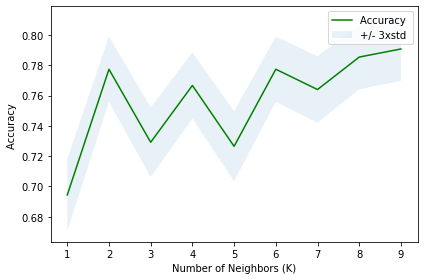

In [50]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [36]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7908847184986595 with k= 9
